In [1]:
import numpy as np
from numpy.linalg import *
from scipy import signal, stats
from scipy.signal import hilbert
from scipy.stats import ranksums, ttest_ind, entropy
from scipy.io import savemat, loadmat
from random import *
from itertools import combinations
from pylab import *
import matplotlib.pyplot as plt
import zlib
from pyentrp import entropy as ent
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from copy import deepcopy
import random

### SC

In [3]:
def calculate(istring: str, dl: int, sigma: float = 0.05, method: str = "overlapping",
                                     states_provided: bool = False, return_states: bool = False):
    """
    Find the (forwards) Statistical Complexity of an input string for given lambda and sigma values
    """
    #if states are not provided, find them, otherwise declare it
    if(type(states_provided)==bool):
        #first, find all states from the input string and the probabilities of presents
        initial_states = find_states(istring,dl,method=method)
        #next, collapse states which have similar probability distributions
        refined_states = collapse_states(initial_states,dl,sigma)
    else:
        #collapse the states based purely on keynames (already done)
        initial_states,refined_states = states_provided,states_provided
    #convert this into a list of probabilities
    probs = collapse_past(refined_states)
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    #if states are not desired, only return complexity
    if(return_states==False):
        return complexity
    else:
        return complexity,refined_states,initial_states

def calculate_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the (forwards) Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate(string,dl,sigma))
    return output

def calculate_bd(istring: str, dl: int, sigma: float = 0.05, method: str ="overlapping",
                              record_states: bool = False):
    """
    Find the forwards, reverse and bidirectional statistical complexity for a string
    """
    #find statistical complexity of forward string and the refined states
    f_sc,f_states,f_states_raw = calculate(istring,dl,sigma,return_states=True,method=method)
    #find complexity of backwards string
    b_sc,b_states,b_states_raw = calculate(istring[::-1],dl,sigma,return_states=True,method=method)
    #collapse the states of forward and reverse complexity based purely on key names
    bd_s = collapse_keys(f_states,b_states)
    #find complexity of bi-directional machine
    bd_sc,bd_states,bd_states_raw = calculate("",dl,sigma,states_provided = bd_s,return_states = True)
    if(record_states==False):
        return f_sc,b_sc,bd_sc
    else:
        return f_sc,b_sc,bd_sc,len(f_states),len(b_states),len(bd_states),len(f_states_raw),len(b_states_raw),len(bd_states_raw)

#Find multiple statistical complexities for forwards, reverse and bidirectional
def calculate_bd_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the forwards, reverse and bidirectional Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate_bd(string,dl,sigma))
    return output

#input string, desired lambda
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions
    """
    #variables used
    i,output_dict = 0,{}
    ## main loop of identifying past and present states
    # Option 1: Non Overlapping
    if(method=="nonoverlapping"):
        while(i+(dl*2)<len(istring)):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=dl
    #Option 2: Overlapping
    else:
        while(i+dl+1<len(istring)):
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=1
    # The last state discovery (main loop misses the final state that can be found)
    try:
        if(method=="nonoverlapping"):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
        else:
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
        if(past not in output_dict):
            output_dict.update({past: {present:1,"total":1}})
        else:
            if(present not in output_dict[past]):
                output_dict[past].update({present:1})
            else:
                output_dict[past][present]+=1
            output_dict[past]["total"]+=1
    except:
        pass
    #collapse counts into probabilities with total counts
    for past in output_dict:
        for present in output_dict[past]:
            if(present!="total"):
                output_dict[past][present]/=output_dict[past]["total"]
    return output_dict

def collapse_states(odict: dict, dl: int, sigma: float = 0.1):
    """
    Collapse a dictionary of state counts into practical states based on a permitted difference sigma
    """
    # Newdict is the collapsed dictionary, temp is used to override newdict when necessary,
    # done_checker is a dictionary used to record the keys already compared
    newdict,temp,done_checker = deepcopy(odict),False,{}
    while(True):
        # If temp is not a boolean, i.e. it's become a dictionary, override newdict
        if(type(temp)!=bool):
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if(past1 not in done_checker):
                done_checker[past1] = {}
            for past2 in newdict:
                if(past1!=past2):
                    if(past2 not in done_checker[past1]):
                        done_checker[past1][past2] = True
                    else:
                        # If these states have already been checked, don't bother checking them again
                        continue
                    # If the difference is less than sigma, merge these states and break the past2 loop
                    if(calculate_difference(newdict[past1],newdict[past2])<sigma):
                        temp = merge_states(newdict,past1,past2,dl)
                        break
            # If the dictionary must be updated, break the past1 loop
            if(type(temp)!=bool):
                break
        # If temp is still a boolean, i.e. there was no merging of states in this loop, break the main loop
        if(type(temp)==bool):
            break
    return newdict

def calculate_difference(past1: dict, past2: dict):
    """
    Calculate the difference between two past states' present state distributions
    """
    difference = -np.inf
    # Cycle through past 1 and check for max differences
    for present in past1:
        # Ensure this check isn't being performed on the total state count
        if(present!="total"):
            if(present not in past2):
                difference = max(difference,past1[present])
            else:
                difference = max(difference,abs(past1[present]-past2[present]))
    # Cycle through past 2
    for present in past2:
        if(present!="total"):
            if(present not in past1):
                difference = max(difference,past2[present])
    return difference

def merge_states(odict: dict, past1: dict, past2: dict, dl: int):
    """
    Merge 2 states and their present state distributions, creating a new state key in a standardised manner
    """
    nprobs = {}
    for present in odict[past1]:
        if(present in odict[past2]):
            nprobs.update({present:(odict[past1][present]+odict[past2][present])/2})
        else:
            nprobs.update({present:odict[past1][present]/2})
    for present in odict[past2]:
        if(present not in odict[past1]):
            nprobs.update({present:odict[past2][present]/2})
    nprobs.update({"total":odict[past1]["total"]+odict[past2]["total"]})
    #create a sorted version of the two pasts combined
    temp,to_sort = past1+past2,[]
    for i in range(int(len(temp)/dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while(len(to_sort)>0):
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    #add the new key and remove the old ones
    ndict = deepcopy(odict)
    ndict.update({newkey:nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

#collapse dictionary of past states and future states into an array of probabilities of the past states
def collapse_past(odict):
    """
    Collapse a dictionary of past states with present state distribtuions into an array of probabilities of the past states
    """
    probs,i,total = np.zeros(len(odict),dtype=float),0,0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i+=1
    return probs/total

def collapse_keys(d1: dict, d2: dict):
    """
    Merge 2 dictionaries of past states with present state distributions
    Note: keys present in both dictionaries lose their probability distributions and only the "total" key remains,
          but this is all that is needed by the point they are merged
    """
    ndict = {}
    for key in d1:
        # as longer keys are created and sorted in a standard way, they are all standardised
        temp = False
        if(key in d2):
            #if the key is in d2, add the two together and mark this has been done
            ndict.update({key:{"total":d1[key]["total"]+d2[key]["total"]}})
            temp = True
        #if no variant of the key was found in d2, add the key as-is
        if(temp==False):
            ndict.update({key:d1[key]})
    for key in d2:
        if(key not in ndict):
            ndict.update({key:d2[key]})
    return ndict

def probs_to_complexity(probs):
    """
    Calculate the Statistical Complexity given an array of past state probabilities
    """
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    # Correct any 0-probabilities to become 0 rather than infinity
    for i in range(len(logprobs)):
        if(probs[i]==0): logprobs[i] = 0.
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    return complexity

def binarise(data,mode="median"):
    """
    Binarise an array of continuous numbers into an array of 0's and 1's (as a string)
    """
    if(type(data)==list or type(data)==tuple):
        data=np.array(data,dtype=float)
    if(isinstance(data,np.ndarray)==False):
        return "Unusable datatype {}".format(type(data))
    if(mode=="median"):
        threshold=np.median(data)
    elif(mode=="mean"):
        threshold=np.mean(data)
    output = np.zeros([len(data)],dtype=int)
    for i in range(len(data)):
        if(data[i]>=threshold):
            output[i]+=1
    # Convert to string
    outstr = ""
    for element in output:
        outstr += str(element)
    return outstr

def multi_binarise(matrix,mode="median"):
    """
    Binarise a 2D matrix (used for calculating multiple statistical complexities)    
    """
    print("Binarising data...")
    # Convert to numpy matrix
    if(type(matrix)==list or type(matrix)==tuple):
        matrix=np.array(matrix,dtype=object)
    output = []
    percent_check = 0.
    for i in range(len(matrix)):
        output.append(binarise(matrix[i],mode))
        # Output progress
        if((i+1)/float(len(matrix))>=percent_check/100.):
            print("{}% of data binarised".format(\
                round(((i+1)/len(matrix))*100,1)))
            percent_check+=10.
    print("Data Binarised")
    return np.array(output, dtype = object)

### LZc

In [5]:
'''
To compute the complexity measure LZc for continuous multidimensional time series X, where rows are time series (minimum 2), and columns are observations, type the following in ipython: 
 
execfile('CompMeasures.py')
LZc(X)


Some functions are shared between the measures.
'''

def Pre(X):
 '''
 Detrend and normalize input data, X a multidimensional time series
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro):
  Z[i,:]=signal.detrend(X[i,:]-mean(X[i,:]), axis=0)
 return Z


##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
'''
##########


def cpr(string):
    """
    Lempel-Ziv-Welch compression of binary input string, e.g., string='0010101'.
    It outputs the size of the dictionary of binary words.
    """
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZc_binary(string):
    """
    Compute LZ complexity for a binary string and normalize it using a shuffled result.
    """
    # Shuffling the string
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    # Calculate complexities
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity by the shuffled result if shuffled_complexity is not zero
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity


def str_col(X):
 '''
 Input: Continuous multidimensional time series
 Output: One string being the binarized input matrix concatenated comlumn-by-column
 '''
 ro,co=shape(X)
 TH=zeros(ro)
 M=zeros((ro,co))
 for i in range(ro):
  M[i,:]=abs(hilbert(X[i,:]))
  TH[i]=mean(M[i,:])

 s=''
 for j in xrange(co):
  for i in xrange(ro):
   if M[i,j]>TH[i]:
    s+='1'
   else:
    s+='0'

 return s

def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))

##########
'''
ACE - Amplitude Coalition Entropy
'''
##########

def map2(psi):
 '''
 Bijection, mapping each binary column of binary matrix psi onto an integer.
 '''
 ro,co=shape(psi) 
 c=zeros(co)
 for t in range(co):
  for j in range(ro):
   c[t]=c[t]+psi[j,t]*(2**j)
 return c

def binTrowH(M):
 '''
 Input: Multidimensional time series M
 Output: Binarized multidimensional time series
 '''
 ro,co=shape(M)
 M2=zeros((ro,co))
 for i in range(ro):
  M2[i,:]=signal.detrend(M[i,:],axis=0)
  M2[i,:]=M2[i,:]-mean(M2[i,:])
 M3=zeros((ro,co))
 for i in range(ro):
  M2[i,:]=abs(hilbert(M2[i,:]))
  th=mean(M2[i,:]) 
  for j in range(co):
   if M2[i,j] >= th :
    M3[i,j]=1
   else:
    M3[i,j]=0 
 return M3

def entropy(string):
 '''
 Calculates the Shannon entropy of a string
 '''
 string=list(string)
 prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
 entropy = - sum([ p * log(p) / log(2.0) for p in prob ])

 return entropy


def ACE(X):
 '''
 Measure ACE, using shuffled reslut as normalization.
 '''
 X=Pre(X)
 ro,co=shape(X)
 M=binTrowH(X)
 E=entropy(map2(M))
 for i in range(ro):
  shuffle(M[i])
 Es=entropy(map2(M))
 return E/float(Es)


##########
'''
SCE - Synchrony Coalition Entropy
'''
##########

def diff2(p1,p2):
 '''
 Input: two series of phases 
 Output: synchrony time series thereof 
 '''
 d=array(abs(p1-p2))
 d2=zeros(len(d))
 for i in range(len(d)):
  if d[i]>pi:
   d[i]=2*pi-d[i]
  if d[i]<0.8:
   d2[i]=1

 return d2


def Psi(X):
 '''
 Input: Multi-dimensional time series X
 Output: Binary matrices of synchrony for each series
 '''
 X=angle(hilbert(X))
 ro,co=shape(X)
 M=zeros((ro, ro-1, co))
 
 #An array containing 'ro' arrays of shape 'ro' x 'co', i.e. being the array of synchrony series for each channel. 
 
 for i in range(ro):
  l=0
  for j in range(ro):
   if i!=j:
    M[i,l]=diff2(X[i],X[j])
    l+=1
 
 return M

def BinRan(ro,co):
 '''
 Create random binary matrix for normalization
 '''

 y=rand(ro,co)
 for i in range(ro):
  for j in range(co):
   if y[i,j]>0.5:
    y[i,j]=1
   else:
    y[i,j]=0
 return y
 
def SCE(X): 
 X=Pre(X)    
 ro,co=shape(X)
 M=Psi(X)
 ce=zeros(ro)
 norm=entropy(map2(BinRan(ro-1,co)))
 for i in range(ro):
  c=map2(M[i])
  ce[i]=entropy(c)

 return mean(ce)/norm,ce/norm

### Quantization of Logistic Map Data

#### Step 1: Generate Multiple Sequences with White Noise

In [8]:
import numpy as np

# Logistic Map Function
def logistic_map(r, x0, n):
    """Generate n iterations of the Logistic Map starting from x0 with growth rate r."""
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = r * x[i-1] * (1 - x[i-1])
    return x

# Function to add white noise
def add_white_noise(sequence, noise_level=0.01):
    """Add white noise to a sequence."""
    noise = np.random.normal(0, noise_level, len(sequence))
    return sequence + noise

# Parameters
bifurcation_params = {
    'Periodic': 3.83,
    'Weak Chaos': 3.9,
    'Strong Chaos': 4.0,
    'Random': None  # Random sequence can be generated separately
}

sequence_length = 1000  # Length of each sequence
n_samples = 50  # Number of sequences to generate for each type
noise_level = 0.01  # Standard deviation of the white noise

# Storage for sequences with noise
sequences_with_noise = {key: [] for key in bifurcation_params}

# Generate sequences and add noise
for sequence_type, r in bifurcation_params.items():
    for _ in range(n_samples):
        if sequence_type == 'Random':
            # Generate random sequence
            sequence = np.random.uniform(0, 1, sequence_length)
        else:
            # Generate logistic map sequence
            x0 = np.random.uniform(0, 1)  # Random initial condition
            sequence = logistic_map(r, x0, sequence_length)
        
        # Add white noise to the sequence
        noisy_sequence = add_white_noise(sequence, noise_level=noise_level)
        
        sequences_with_noise[sequence_type].append(noisy_sequence)

# Convert lists to numpy arrays for easier processing later
for key in sequences_with_noise:
    sequences_with_noise[key] = np.array(sequences_with_noise[key])

# Output example sequences
print("Example sequences with white noise added:")
for key in sequences_with_noise:
    print(f"\n{key} sequence example (first sequence):")
    print(sequences_with_noise[key][0])

Example sequences with white noise added:

Periodic sequence example (first sequence):
[0.15521462 0.51839569 0.96551078 0.17287818 0.51215266 0.9425149
 0.15765739 0.5394965  0.97244208 0.15383149 0.49466093 0.94431326
 0.17600263 0.52016329 0.96039125 0.15319171 0.52984238 0.95150225
 0.1584077  0.50541529 0.95625428 0.15523321 0.49593331 0.98499111
 0.14164163 0.4967678  0.97137133 0.16732506 0.50328583 0.94333815
 0.16072154 0.48915124 0.94337202 0.15414225 0.52407154 0.9696504
 0.16323349 0.49056396 0.96712919 0.17115264 0.49640976 0.95335525
 0.15298992 0.51638902 0.96777167 0.17557625 0.49051553 0.95722694
 0.13258777 0.49813344 0.94928194 0.16135188 0.49993571 0.96558505
 0.16635073 0.50021417 0.95185401 0.13640191 0.50496393 0.9458092
 0.15765613 0.5240983  0.95820137 0.15743377 0.50561306 0.96847421
 0.16644346 0.48409354 0.95393277 0.15086179 0.51272802 0.97721671
 0.15790155 0.51062314 0.94438617 0.16491099 0.51379684 0.95310286
 0.15909412 0.49624016 0.95028939 0.14557966 

#### Step 2: Calculate the Complexity Measures (2A. Lempel-Ziv")

In [10]:
# Calculate Lempel-Ziv Complexity for each sequence
lz_complexities = {key: [] for key in sequences_with_noise}

for sequence_type in sequences_with_noise:
    for sequence in sequences_with_noise[sequence_type]:
        binarized_sequence = binarise(sequence, mode="median")
        lz_complexity = LZc_binary(binarized_sequence)
        lz_complexities[sequence_type].append(lz_complexity)

# Convert lists to numpy arrays for easier analysis
for key in lz_complexities:
    lz_complexities[key] = np.array(lz_complexities[key])

# Output example Lempel-Ziv complexities
print("Example Lempel-Ziv complexities:")
for key in lz_complexities:
    print(f"{key}: {lz_complexities[key][:5]}")  # Print first 5 complexities for each type

Example Lempel-Ziv complexities:
Periodic: [0.72361809 0.74111675 0.74       0.73604061 0.73096447]
Weak Chaos: [0.81818182 0.805      0.81       0.83417085 0.8030303 ]
Strong Chaos: [0.985      1.00512821 1.         0.99497487 1.01522843]
Random: [0.99497487 1.         1.01522843 1.01005025 1.01010101]


#### Step 2B. Statistical Complexities

In [12]:
# Initialize a dictionary to store the SC values
sc_complexities = {key: [] for key in sequences_with_noise}

# Initialize parameters
dl = 3
sigma = 0.05 

# Calculate Statistical Complexity for each sequence
for sequence_type in sequences_with_noise:
    for sequence in sequences_with_noise[sequence_type]:
        binarized_sequence = binarise(sequence, mode="median")
        sc_complexity = calculate(binarized_sequence, dl=dl, sigma=sigma)
        sc_complexities[sequence_type].append(sc_complexity)

# Convert lists to numpy arrays for easier analysis
for key in sc_complexities:
    sc_complexities[key] = np.array(sc_complexities[key])

# Output example Statistical Complexities
print("Example Statistical Complexities:")
for key in sc_complexities:
    print(f"{key}: {sc_complexities[key][:5]}")  # Print first 5 complexities for each type

Example Statistical Complexities:
Periodic: [2.25195988 2.60660456 2.31741544 2.28645959 2.25089818]
Weak Chaos: [2.45131767 2.39774728 2.53362924 2.44617794 2.52797924]
Strong Chaos: [2.72139012 2.7146919  2.74946499 2.74702744 2.23189163]
Random: [2.23972296 2.74699769 2.49806838 2.50011395 2.49981909]


#### Step 3: Perform ANOVA and Tukey's test

In [14]:
# Perform ANOVA for Lempel-Ziv Complexity
print("\nANOVA for Lempel-Ziv Complexity:")
f_val_lz, p_val_lz = stats.f_oneway(
    lz_complexities['Periodic'], 
    lz_complexities['Weak Chaos'], 
    lz_complexities['Strong Chaos'], 
    lz_complexities['Random']
)
print(f"F-statistic: {f_val_lz}, p-value: {p_val_lz}")

# If significant, perform Tukey's test for Lempel-Ziv Complexity
if p_val_lz < 0.05:
    all_lz_values = np.concatenate([
        lz_complexities['Periodic'],
        lz_complexities['Weak Chaos'],
        lz_complexities['Strong Chaos'],
        lz_complexities['Random']
    ])

    lz_labels = ['Periodic'] * n_samples + ['Weak Chaos'] * n_samples + ['Strong Chaos'] * n_samples + ['Random'] * n_samples

    tukey_lz = pairwise_tukeyhsd(endog=all_lz_values, groups=lz_labels, alpha=0.05)
    print("\nTukey's test for Lempel-Ziv Complexity:")
    print(tukey_lz)

# Perform ANOVA for Statistical Complexity
print("\nANOVA for Statistical Complexity:")
f_val_sc, p_val_sc = stats.f_oneway(
    sc_complexities['Periodic'], 
    sc_complexities['Weak Chaos'], 
    sc_complexities['Strong Chaos'], 
    sc_complexities['Random']
)
print(f"F-statistic: {f_val_sc}, p-value: {p_val_sc}")

# If significant, perform Tukey's test for Statistical Complexity
if p_val_sc < 0.05:
    all_sc_values = np.concatenate([
        sc_complexities['Periodic'],
        sc_complexities['Weak Chaos'],
        sc_complexities['Strong Chaos'],
        sc_complexities['Random']
    ])

    sc_labels = ['Periodic'] * n_samples + ['Weak Chaos'] * n_samples + ['Strong Chaos'] * n_samples + ['Random'] * n_samples

    tukey_sc = pairwise_tukeyhsd(endog=all_sc_values, groups=sc_labels, alpha=0.05)
    print("\nTukey's test for Statistical Complexity:")
    print(tukey_sc)


ANOVA for Lempel-Ziv Complexity:
F-statistic: 7282.955329298313, p-value: 1.1085832532993529e-200

Tukey's test for Lempel-Ziv Complexity:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    Periodic       Random    0.263    0.0  0.2574  0.2686   True
    Periodic Strong Chaos   0.2602    0.0  0.2546  0.2658   True
    Periodic   Weak Chaos    0.084    0.0  0.0784  0.0896   True
      Random Strong Chaos  -0.0028 0.5676 -0.0085  0.0028  False
      Random   Weak Chaos   -0.179    0.0 -0.1846 -0.1734   True
Strong Chaos   Weak Chaos  -0.1762    0.0 -0.1818 -0.1705   True
----------------------------------------------------------------

ANOVA for Statistical Complexity:
F-statistic: 7.9282502850597805, p-value: 5.120074086383982e-05

Tukey's test for Statistical Complexity:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   gr

### Extend Sequence Length

In [16]:
# Step 1: Define Sequence Lengths and Initialize Storage
sequence_lengths = [200, 500, 1000, 1500, 2000, 3000]
n_samples = 50  # Number of sequences per type and length
bifurcation_params = {
    'Periodic': 3.83,
    'Weak Chaos': 3.9,
    'Strong Chaos': 4.0,
    'Random': None  # Random sequence can be generated separately
}
noise_level = 0.01  # Standard deviation of the white noise

# Storage for complexities
lz_complexities_all = {key: {length: [] for length in sequence_lengths} for key in bifurcation_params}
sc_complexities_all = {key: {length: [] for length in sequence_lengths} for key in bifurcation_params}

# Step 2: Generate Sequences, Add Noise, and Calculate Complexities
for length in sequence_lengths:
    sequences_with_noise = {key: [] for key in bifurcation_params}
    
    for sequence_type, r in bifurcation_params.items():
        for _ in range(n_samples):
            if sequence_type == 'Random':
                # Generate random sequence
                sequence = np.random.uniform(0, 1, length)
            else:
                # Generate logistic map sequence
                x0 = np.random.uniform(0, 1)  # Random initial condition
                sequence = logistic_map(r, x0, length)
            
            # Add white noise to the sequence
            noisy_sequence = add_white_noise(sequence, noise_level=noise_level)
            sequences_with_noise[sequence_type].append(noisy_sequence)
        
        # Calculate complexities for each sequence
        for sequence in sequences_with_noise[sequence_type]:
            binarized_sequence = binarise(sequence, mode="median")
            lz_complexity = LZc_binary(binarized_sequence)
            sc_complexity = calculate(binarized_sequence, dl=2, sigma=0.05)
            
            # Store the complexities
            lz_complexities_all[sequence_type][length].append(lz_complexity)
            sc_complexities_all[sequence_type][length].append(sc_complexity)

# Step 3: Average the Complexities Across Sequence Lengths
average_lz_complexities = {key: [] for key in bifurcation_params}
average_sc_complexities = {key: [] for key in bifurcation_params}

for sequence_type in bifurcation_params:
    for length in sequence_lengths:
        avg_lz = np.mean(lz_complexities_all[sequence_type][length])
        avg_sc = np.mean(sc_complexities_all[sequence_type][length])
        average_lz_complexities[sequence_type].append(avg_lz)
        average_sc_complexities[sequence_type].append(avg_sc)

# Step 4: Perform ANOVA on the Averaged Complexities
print("\nANOVA for Averaged Lempel-Ziv Complexity:")
f_val_lz, p_val_lz = stats.f_oneway(
    average_lz_complexities['Periodic'], 
    average_lz_complexities['Weak Chaos'], 
    average_lz_complexities['Strong Chaos'], 
    average_lz_complexities['Random']
)
print(f"F-statistic: {f_val_lz}, p-value: {p_val_lz}")

# If significant, perform Tukey's test for Averaged LZc
if p_val_lz < 0.05:
    all_avg_lz_values = np.concatenate([
        average_lz_complexities['Periodic'],
        average_lz_complexities['Weak Chaos'],
        average_lz_complexities['Strong Chaos'],
        average_lz_complexities['Random']
    ])

    avg_lz_labels = (
        ['Periodic'] * len(sequence_lengths) +
        ['Weak Chaos'] * len(sequence_lengths) +
        ['Strong Chaos'] * len(sequence_lengths) +
        ['Random'] * len(sequence_lengths)
    )

    tukey_avg_lz = pairwise_tukeyhsd(endog=all_avg_lz_values, groups=avg_lz_labels, alpha=0.05)
    print("\nTukey's test for Averaged Lempel-Ziv Complexity:")
    print(tukey_avg_lz)

print("\nANOVA for Averaged Statistical Complexity:")
f_val_sc, p_val_sc = stats.f_oneway(
    average_sc_complexities['Periodic'], 
    average_sc_complexities['Weak Chaos'], 
    average_sc_complexities['Strong Chaos'], 
    average_sc_complexities['Random']
)
print(f"F-statistic: {f_val_sc}, p-value: {p_val_sc}")

# If significant, perform Tukey's test for Averaged SC
if p_val_sc < 0.05:
    all_avg_sc_values = np.concatenate([
        average_sc_complexities['Periodic'],
        average_sc_complexities['Weak Chaos'],
        average_sc_complexities['Strong Chaos'],
        average_sc_complexities['Random']
    ])

    avg_sc_labels = (
        ['Periodic'] * len(sequence_lengths) +
        ['Weak Chaos'] * len(sequence_lengths) +
        ['Strong Chaos'] * len(sequence_lengths) +
        ['Random'] * len(sequence_lengths)
    )

    tukey_avg_sc = pairwise_tukeyhsd(endog=all_avg_sc_values, groups=avg_sc_labels, alpha=0.05)
    print("\nTukey's test for Averaged Statistical Complexity:")
    print(tukey_avg_sc)


ANOVA for Averaged Lempel-Ziv Complexity:
F-statistic: 56.44370169970968, p-value: 6.086528841838123e-10

Tukey's test for Averaged Lempel-Ziv Complexity:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    Periodic       Random   0.2608    0.0  0.1923  0.3292   True
    Periodic Strong Chaos    0.257    0.0  0.1886  0.3255   True
    Periodic   Weak Chaos    0.084 0.0129  0.0155  0.1524   True
      Random Strong Chaos  -0.0037 0.9987 -0.0721  0.0647  False
      Random   Weak Chaos  -0.1768    0.0 -0.2452 -0.1084   True
Strong Chaos   Weak Chaos  -0.1731    0.0 -0.2415 -0.1047   True
----------------------------------------------------------------

ANOVA for Averaged Statistical Complexity:
F-statistic: 33.1111626045063, p-value: 5.956422110712821e-08

Tukey's test for Averaged Statistical Complexity:
      Multiple Comparison of Means - 

### Plot Confidence Intervals

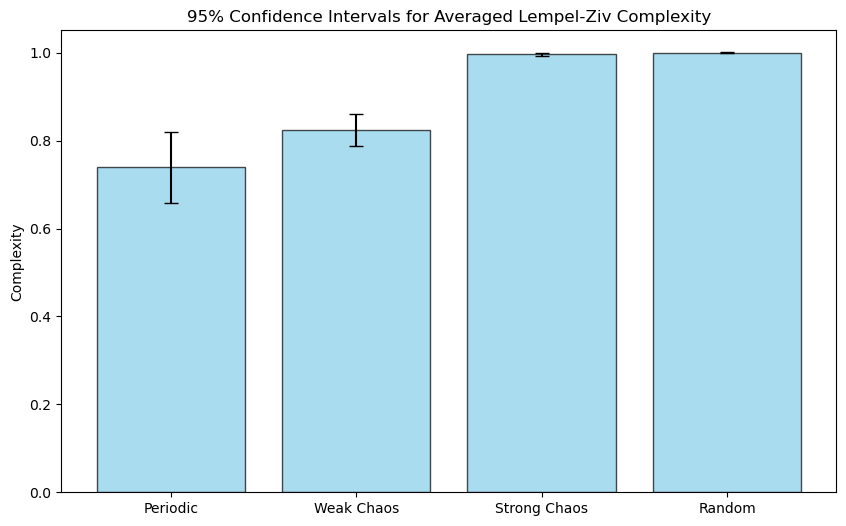

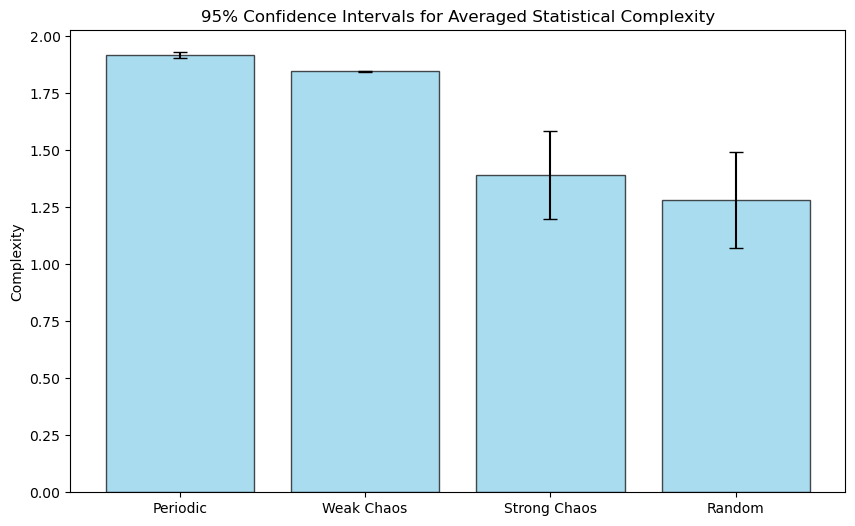

In [18]:
# Function to plot confidence intervals
def plot_confidence_intervals(average_complexities, title):
    sequence_types = list(average_complexities.keys())
    means = [np.mean(average_complexities[seq_type]) for seq_type in sequence_types]
    errors = [
        stats.sem(average_complexities[seq_type]) * stats.t.ppf((1 + 0.95) / 2., len(average_complexities[seq_type]) - 1)
        for seq_type in sequence_types
    ]

    plt.figure(figsize=(10, 6))
    plt.bar(sequence_types, means, yerr=errors, capsize=5, color='skyblue', alpha=0.7, edgecolor='black')
    plt.ylabel('Complexity')
    plt.title(title)

    file_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\q3.png'
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot Confidence Intervals for Averaged Lempel-Ziv Complexity
plot_confidence_intervals(average_lz_complexities, '95% Confidence Intervals for Averaged Lempel-Ziv Complexity')

# Plot Confidence Intervals for Averaged Statistical Complexity
plot_confidence_intervals(average_sc_complexities, '95% Confidence Intervals for Averaged Statistical Complexity')

### Correlation Analysis

In [20]:
import numpy as np
from scipy.stats import pearsonr

# Combine SC and LZc values across all sequence types and lengths
all_lz_values = []
all_sc_values = []

for sequence_type in bifurcation_params:
    for length in sequence_lengths:
        all_lz_values.extend(lz_complexities_all[sequence_type][length])
        all_sc_values.extend(sc_complexities_all[sequence_type][length])

# Convert to numpy arrays for correlation calculation
all_lz_values = np.array(all_lz_values)
all_sc_values = np.array(all_sc_values)

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(all_lz_values, all_sc_values)

print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: -0.6926358217705054
P-value: 3.4322198347828515e-172
